In [1]:
from class_definitions import Program, Merit, Target, Observation, Plan, Night
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astroplan
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz
import merits
import astropy.units as u
from tqdm.notebook import tqdm
import scheduler
from datetime import date, timedelta, datetime

In [2]:
# Define global observer location
lasilla = astroplan.Observer.at_site("lasilla")

In [3]:
# Define the programs
# Eventually this would be imported from the gitlab with the files.
prog703 = Program(703, 13, instrument="CORALIE")
prog708 = Program(708, 7, instrument="CORALIE")
prog600 = Program(600, 2, instrument="CORALIE")

In [4]:
start_datetime = Time("2023-10-20 01:50:00")


In [5]:
# Time(datetime.combine(date(2023, 10, 20), datetime.min.time()))
start_datetime.datetime.date()
night = Night(start_datetime.datetime.date() - timedelta(days=1))

## Define a target and add merits

In [6]:
# Define merits
cadence_merit = Merit("Cadence", merits.cadence, 
                      merit_type="efficiency", 
                      parameters={"delay": TimeDelta(4*u.day), "alpha":0.05})
airmass_merit = Merit("Airmass", merits.airmass, merit_type="veto", parameters={'max':1.5})
altitude_merit = Merit("Altitude", merits.altitude, merit_type="veto")
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto", parameters={'which':'nautical'})
culmination_merit = Merit("Culmination", merits.culmination, merit_type="efficiency")

In [7]:
# Test targets for the night of 2023-10-20
test_targets = ['HD224953A', 'CD-3931', 'CD-33501', 'BD-21397', 'HD16157',
                'CD-231056', 'CD-341770', 'HD32965', 'HD35650', 'HD274919',
                'BD-221344', 'CD-492340A', 'CD-422626', 'HD51199B', 'BD-141750',
                'BD-191855', 'HD58760', 'CD-363646', 'HD66020',
                'CD-81812', 'HD214100', 'HD218294']

# Create the targets
targets = []
for tar_name in tqdm(test_targets):
    last_obs = start_datetime-5*u.day
    target = Target(tar_name, prog708, coords=SkyCoord.from_name(tar_name), last_obs=last_obs)
    target.add_merit(cadence_merit)
    # target.add_merit(airmass_merit)
    target.add_merit(culmination_merit)
    target.add_merit(altitude_merit)
    target.add_merit(at_night_merit)
    targets.append(target)

  0%|          | 0/22 [00:00<?, ?it/s]

In [8]:
len(test_targets)

22

In [9]:
print(targets[4])

Target(Name: {self.name},
       Program: 708,
       Coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (38.59402579, -43.79635253)>,
       Last observation: 2023-10-15 01:50:00.000,
       Merits: [Merit(Cadence, efficiency), Merit(Culmination, efficiency), Merit(Altitude, veto), Merit(AtNight, veto)],
       Time share allocated: 7,
       Time share current: 0.0,
       Time share pct diff: 0.0)


In [10]:
test_observtions = [Observation(target, start_time=start_datetime, exposure_time=TimeDelta(15*u.min), night=night) for target in targets]

## Test the merits

In [11]:
test_obs = test_observtions[0]
print(f"Cadence merit = {cadence_merit.evaluate(test_obs)}")

Cadence merit = 0.816227766016838


In [12]:
print(f"Airmass merit = {airmass_merit.evaluate(test_obs, verbose=True)}")

Airmasses: [1.30544365 1.30435938 1.30330519 1.30228098 1.30128668 1.30032221
 1.29938748 1.29848243 1.29760697 1.29676104]
Max airmass: 1.3054436493756243
Airmass within limits, return merit.
Airmass merit = 0.766023106763962


In [13]:
print(f"Altitude merit = {altitude_merit.evaluate(test_obs)}")

Altitude merit = 1.0


In [14]:
print(f"Culmination merit = {culmination_merit.evaluate(test_obs, verbose=True)}")

Current altitude: 49.99809819154009
Max altitude: 51.10576136817663
Min altitude: 25.59682474251643
Altitude proportion: 0.9565774460577745
Culmination merit = 0.9565774460577745


In [15]:
test_obs.evaluate_score(verbose=True)

Fairness: 1
Sensibility: 1.0
Efficiency: 0.8864026060373063
Rank score: 0.8864026060373063


0.8864026060373063

## Test the observation planning

In [19]:
# Create the plan
# remove test_obs from the list
test_observtions.remove(test_obs)
plan = scheduler.forwardP(test_obs, test_observtions, 15)

ValueError: list.remove(x): x not in list

In [17]:
print(plan)

Plan(
     Score: 0.8165875989860485,
     Observations: 
         [Observation(Target: HD224953A,
            Start time: 2023-10-20 01:50:00.000,
            Exposure time: 0.010416666666666666,
            Score: 0.8864026060373063), Observation(Target: HD218294,
            Start time: 2023-10-20 02:05:00.000,
            Exposure time: 0.010416666666666666,
            Score: 0.907502127668546), Observation(Target: CD-3931,
            Start time: 2023-10-20 02:20:00.000,
            Exposure time: 0.010416666666666666,
            Score: 0.8818612497190568), Observation(Target: CD-81812,
            Start time: 2023-10-20 02:35:00.000,
            Exposure time: 0.010416666666666666,
            Score: 0.8668988583050121), Observation(Target: HD214100,
            Start time: 2023-10-20 02:50:00.000,
            Exposure time: 0.010416666666666666,
            Score: 0.8368697444163548), Observation(Target: CD-33501,
            Start time: 2023-10-20 03:05:00.000,
            Ex

## Plotting tests

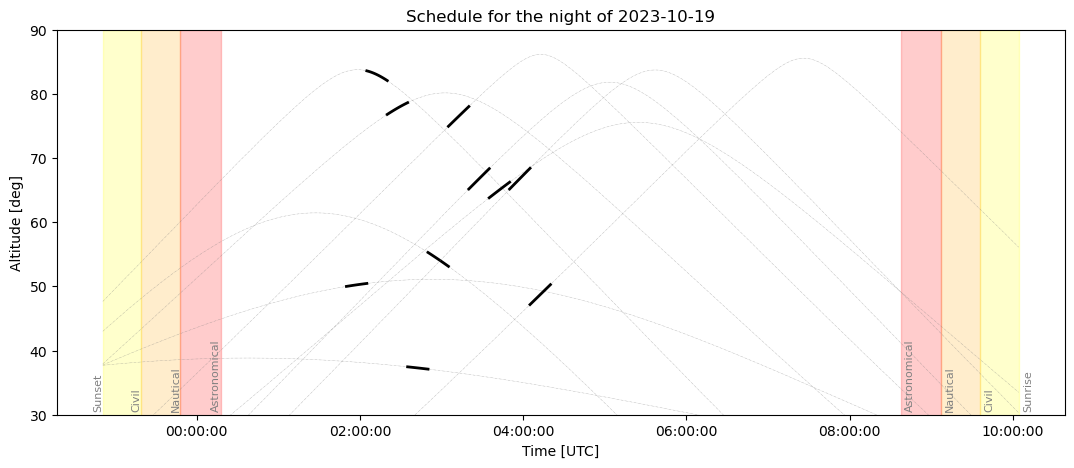

In [18]:
plan.plot()

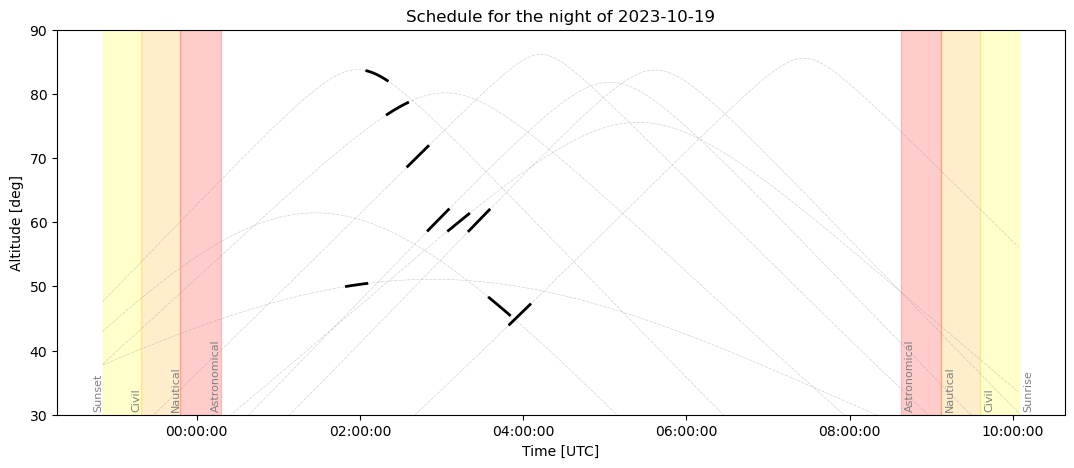

In [17]:
plan.plot()

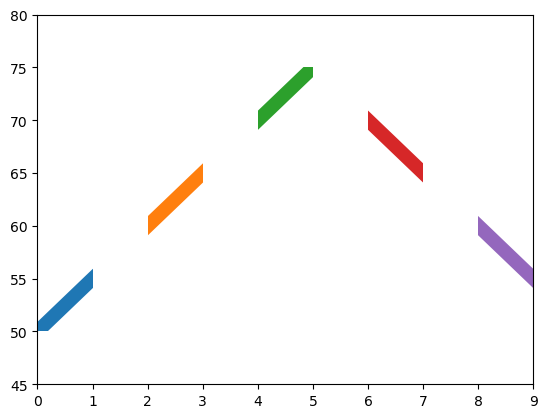

In [83]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from matplotlib.path import Path

# fig, ax = plt.subplots()

# # Example data
# times = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# altitudes = [50, 55, 60, 65, 70, 75, 70, 65, 60, 55]

# for i in range(0, len(times) - 1, 2):
#     # Define the path for the line segment
#     vertices = [(times[i], altitudes[i]), (times[i + 1], altitudes[i + 1])]
#     codes = [Path.MOVETO, Path.LINETO]
#     path = Path(vertices, codes)

#     # Define the rectangular patch to clip the path, without adding it to the axes
#     rect = patches.Rectangle((times[i], min(altitudes)), 
#                              times[i + 1] - times[i], max(altitudes) - min(altitudes), visible=False)
    
#     # Do NOT add the patch to the axes. Instead, just set it as the clip path for the line segment.
#     ax.add_patch(rect)
#     line, = ax.plot(times[i:i + 2], altitudes[i:i + 2], lw=10)
#     line.set_clip_path(rect)

# ax.set_xlim(min(times), max(times))
# ax.set_ylim(min(altitudes) - 5, max(altitudes) + 5)
# plt.show()
